In [1]:
import os

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis
import numpy as np

import json

import ale
from ale import util
from ale.drivers.mex_drivers import MexHrscPds3NaifSpiceDriver, MexHrscIsisLabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# url = 'https://pds-geosciences.wustl.edu/mex/mex-m-hrsc-3-rdr-ext2-v4/mexhrs_4002/data/5270/h5270_0000_ir3.img'

# !wget -N -P data/ {url}
# fileName = 'data/' + os.path.split(url)[1]
fileName = 'data/h5270_0000_ir2.img'

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.hrsc2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid', ckpredicted=True, spkpredicted=True)
except ProcessError as e:
    print(e.stderr)
    
kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)
usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, verbose=False)

csm_isd = os.path.splitext(fileName)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)

In [4]:
camera = knoten.csm.create_csm(fileName, verbose=True)

Trying plugin UsgsAstroPluginCSM
Trying model USGS_ASTRO_FRAME_SENSOR_MODEL
Warning in function UsgsAstroFrameSensorModel::constructStateFromIsd(): "Sensor position does not have 3 values."
Warning in function UsgsAstroFrameSensorModel::constructStateFromIsd(): "Sensor velocity does not have 3 values."
Warning in function UsgsAstroFrameSensorModel::constructStateFromIsd(): "Sensor orientation quaternion does not have 4 values."
Warning in function UsgsAstroFrameSensorModel::canModelBeConstructedFromISD(): "Could not create model [USGS_ASTRO_FRAME_SENSOR_MODEL] with error [Could not construct model [USGS_ASTRO_FRAME_SENSOR_MODEL] with error [ISD is invalid for creating the sensor model.]]"
Failed!
Trying model USGS_ASTRO_LINE_SCANNER_SENSOR_MODEL
Success!


In [5]:
usgscsm_json = json.loads(usgscsm_str)
n_lines = usgscsm_json['image_lines']
n_samples = usgscsm_json['image_samples']

In [6]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

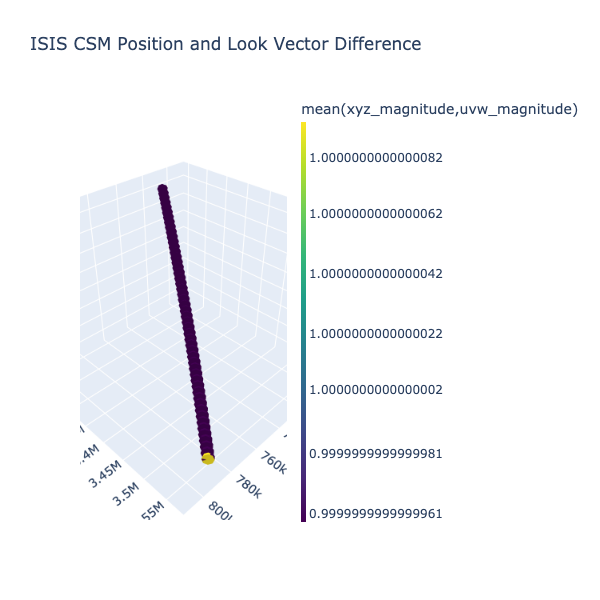

In [7]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

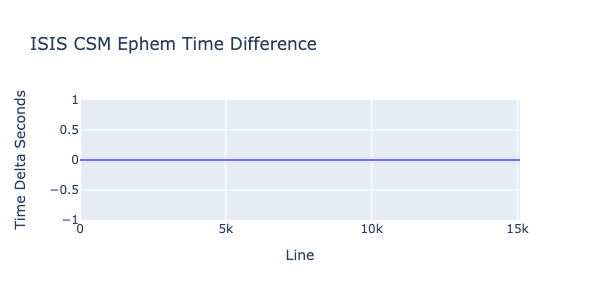

In [8]:
Image(csmisis_diff_ephem_plot_bytes)

In [9]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,0.000126,0.000463,0.000187,-7.365194e-10,-7.929299e-10,1.267115e-09
std,0.000305,0.001279,0.000577,3.088162e-09,1.548364e-09,2.484177e-09
min,-0.000157,-0.000347,-0.000169,-9.742921e-09,-5.560907e-09,-3.254590e-09
25%,-0.000021,-0.000022,-0.000072,-1.617043e-09,-1.265500e-09,-1.369893e-11
50%,0.000044,0.000070,0.000009,-1.401185e-12,-9.160284e-12,1.710582e-11
75%,0.000149,0.000243,0.000129,1.610601e-12,1.135220e-11,1.925639e-09
max,0.001247,0.006090,0.002684,7.307933e-09,1.979817e-09,8.660461e-09


In [10]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

/Users/acpaquette/repos/knoten/knoten/vis.py:62: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



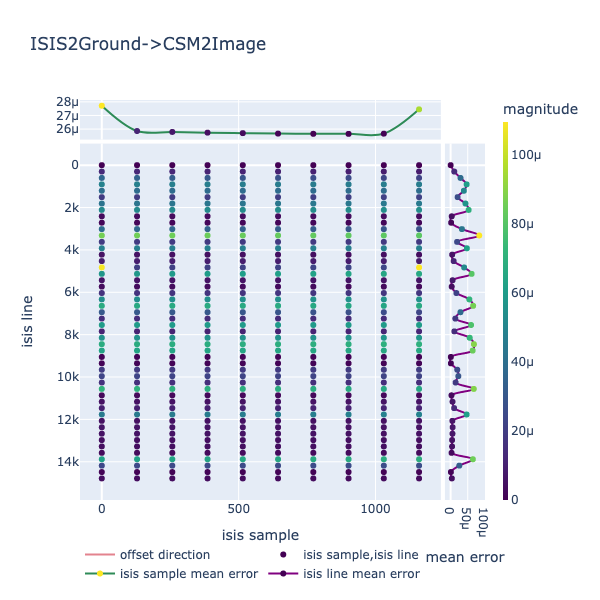

In [11]:
Image(isis2csm_plot.to_image())

In [12]:
isis2csm_data[['diff sample', 'diff line']].describe()

,diff sample,diff line
count,5.000000e+02,5.000000e+02
mean,-3.379507e-06,-4.252599e-06
std,1.974636e-05,2.947663e-05
min,-6.175285e-05,-1.093517e-04
25%,-8.400527e-06,-1.416889e-05
50%,-6.366463e-12,5.193224e-07
75%,3.906875e-06,4.540186e-06
max,4.925851e-05,6.668614e-05


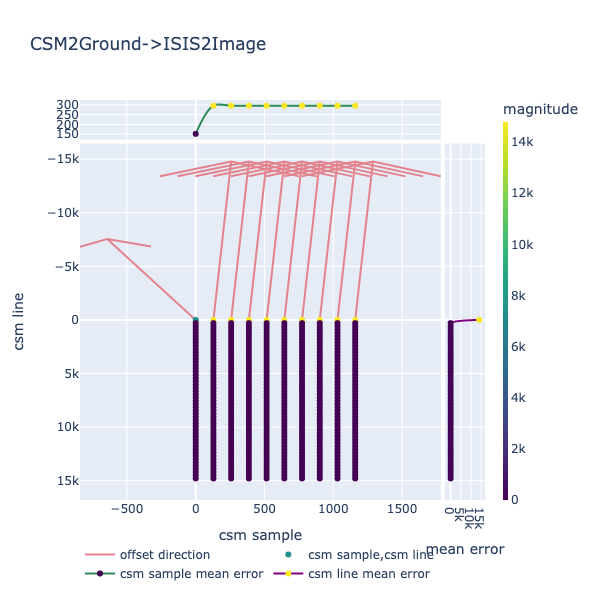

In [13]:
Image(csm2isis_plot.to_image())

In [14]:
csm2isis_data[['diff sample', 'diff line']].describe()

,diff sample,diff line
count,5.000000e+02,500.000000
mean,1.031403e+00,-281.255799
std,3.358551e+01,1994.505518
min,-6.435000e+02,-14786.240192
25%,-4.256997e-06,-0.000007
50%,-4.293176e-07,0.000002
75%,8.822621e-06,0.000047
max,1.288000e+02,0.000336


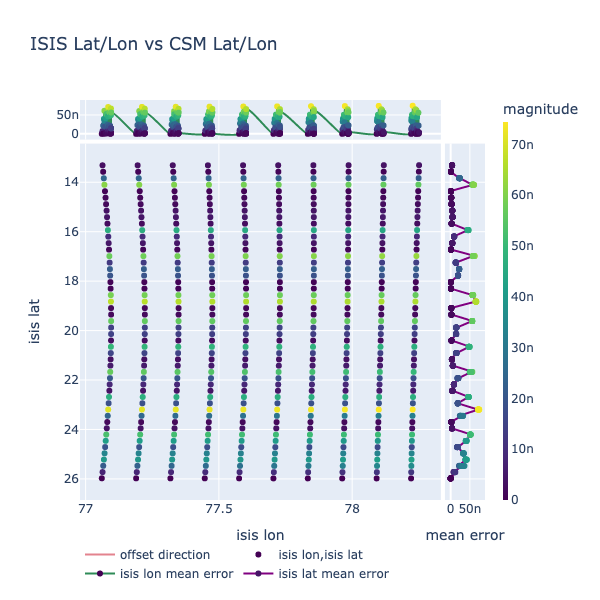

In [15]:
Image(isiscsm_plotlatlon.to_image())

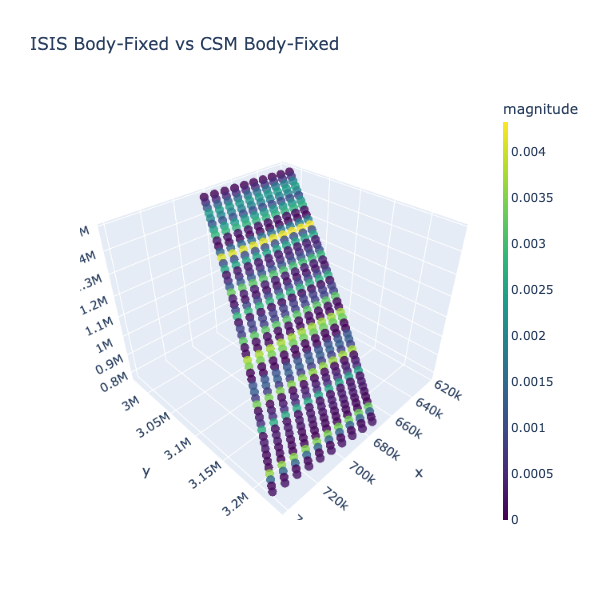

In [16]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,-0.212864,0.000080,-0.000385
std,1.653951,0.000379,0.001183
min,-3.136294,-0.001149,-0.003530
25%,-1.462640,-0.000039,-0.000673
50%,-0.816276,0.000010,-0.000012
75%,1.439861,0.000228,0.000047
max,3.020030,0.001130,0.002077
